# Install statements

In [23]:
! pip install fast_ml --quiet
! pip install opencv-python
! pip install pandas
! pip install --upgrade pip
! pip install seaborn
! pip install tensorflow
! pip install tqdm

# Initial setup (Always run)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from fast_ml.model_development import train_valid_test_split
import pathlib

2.17.0


# Preprocessing 

In [4]:
tsinghua_image_path = os.getcwd()+'/dog_classes'

In [2]:
# Function to load and preprocess a single image
# Image is resized, converted to array, and normalised
def parse_image(image_path, target_size=(224, 224)):
    # Load and decode the image
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)  # Convert to array (height, width, channels)

    # Normalize to [0, 1]
    image /= 255.0  # Normalization is often necessary for model training
  
    return image

# Create a function to calculate the mean over the entire dataset
def compute_dataset_mean(image_paths):
    total_sum = np.zeros(3)  # We split into 3, to calculate the pr channel mean - good for deep learning models
    total_count = 0

    for img_path in image_paths:

        full_img_path = os.path.join(tsinghua_image_path, img_path)  # Join the base path with the image path

        parsed_img = parse_image(full_img_path, target_size=(224, 224))

        total_sum += np.mean(parsed_img, axis=(0, 1))  # Mean over width, height for each channel -> we only calculate the mean over the one picture here
        total_count += 1

    dataset_mean = total_sum / total_count
    return dataset_mean

# Compute the feature wise mean (over the whole dataset)
#dataset_mean = compute_dataset_mean(df['Image path'].tolist())
#print("Feature wise Mean: ", dataset_mean)

# Function to apply feature-wise centering
def zero_centering(image, dataset_mean):
    return image - dataset_mean

# Load images into the DataFrame and apply zero-centering
def load_images_into_dataframe(df, dataset_mean):
    # Create a list to hold the processed images
    images = []

    for image_path in df['Image path']:
        full_image_path = os.path.join("dog_classes/", image_path)
        #print(full_image_path)
        image_array = parse_image(full_image_path)  # Load and preprocess the image - is array
        image = zero_centering(image_array, dataset_mean)  # Apply zero centering
        #image /= 255.0
        images.append(image)  # Append the processed image to the list

    # Add the images as a new column in the DataFrame
    df.insert(2, 'Image', images)

    return df

# Load images into the DataFrame
#df = load_images_into_dataframe(df, dataset_mean)

# Now the DataFrame contains paths, labels, and processed images
#df.head(5)


# Visualize data

In [23]:
tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

print('Number of dog breeds: ', len(classes))

#Make empty array to save info about dog breeds and their frequencies
class_names_and_frequencies = []

#Loop through all classes
for class_name in classes:
    class_path = os.path.join(tsinghua_image_path, class_name)
    
    if class_name.startswith('.'):
        print(f"Skipping hidden file: {class_name}")
        continue
    
    dog_name = class_name.split('-')[2] #We only want after the second occurence of "-" in the directory name
    
    
    dog_frequency = len(os.listdir(class_path))
    class_names_and_frequencies.append((dog_name, dog_frequency))

#Get the dataframe
df = pd.DataFrame(class_names_and_frequencies, columns = ['Breeds', 'Frequency'])
print('Total number of images :', df['Frequency'].sum())

Number of dog breeds:  131
Skipping hidden file: .DS_Store
Total number of images : 70432


In [24]:
#Check if it looks alright
df.head()

,Breeds,Frequency
0,schipperke,201
1,Australian_Shepherd,245
2,Shetland_sheepdog,274
3,black_and_tan_coonhound,225
4,Gordon_setter,228


<AxesSubplot: title={'center': 'Frequency of dog breeds in descending order'}, xlabel='Frequency', ylabel='Breeds'>

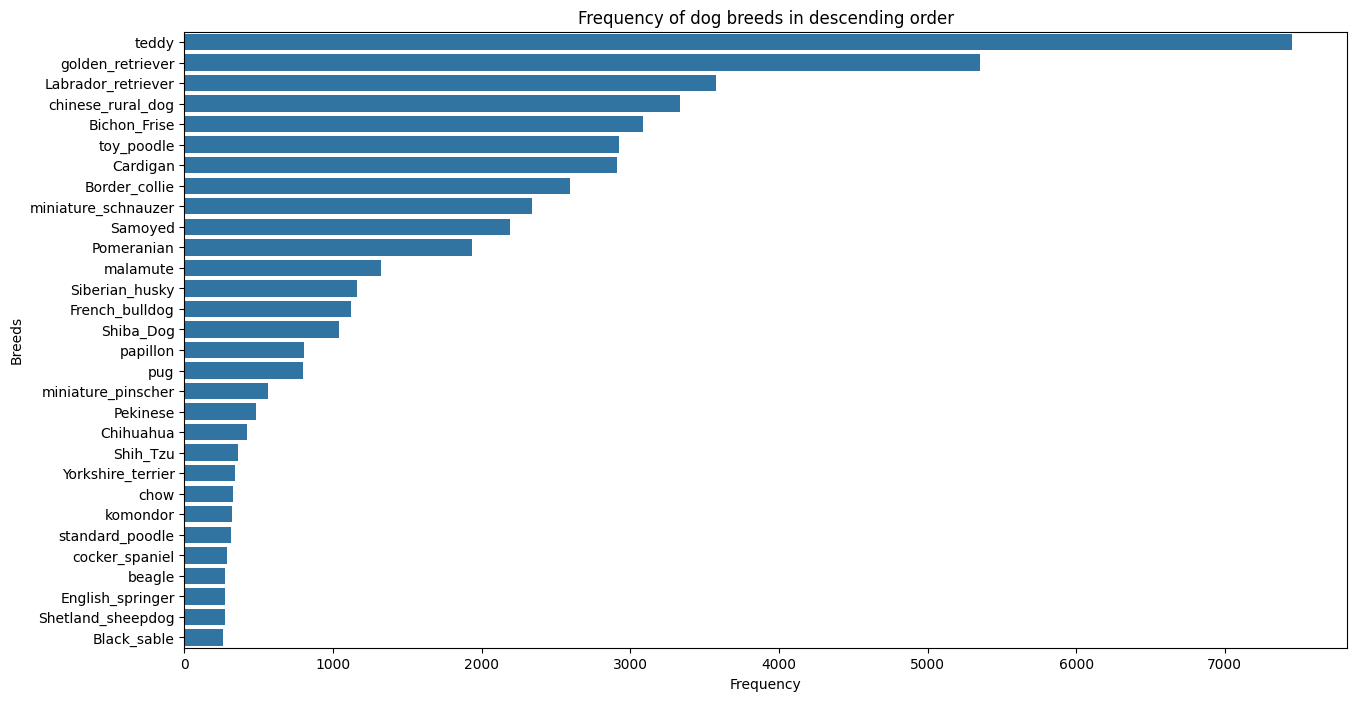

In [25]:
#Plot the distribution of dog breeds
plt.figure(figsize=(15,8))
plt.title('Frequency of dog breeds in descending order')
sns.barplot(x = 'Frequency', y = 'Breeds', data = df.sort_values('Frequency', ascending = False).head(30))

# Preprocessing

In [13]:
#Array containing all data
dogs = []

tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

classes = classes[:]
print(len(classes))

for dog_breed in classes:
    if dog_breed.startswith('.'):
        print(f"Skipping hidden file: {dog_breed}")
        continue
    dog_breed_path = os.path.join(tsinghua_image_path, dog_breed)
    for image_id in os.listdir(dog_breed_path):
        path = os.path.join(dog_breed_path, image_id)
        label = dog_breed.split('-')[2]
        dogs.append((path, label))

df = pd.DataFrame(dogs, columns = ['Image path', 'Label'])
print('Shape of dataframe :', df.shape)

df.head()

131
Skipping hidden file: .DS_Store
Shape of dataframe : (70432, 2)


,Image path,Label
0,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke
1,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke
2,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke
3,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke
4,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke


In [39]:
# Compute the dataset mean
data_mean = compute_dataset_mean(df['Image path'].tolist())
print("Dataset Mean: ", data_mean)

df_with_images = load_images_into_dataframe(df, data_mean)

# Now the DataFrame contains paths, labels, and processed images
df.head(5)

Dataset Mean:  [0.49053261 0.47621457 0.41360671]


KeyboardInterrupt: 

# Train, validation, and test split

Now we can split the Dataframe, `df`, that contains all our data into training, validation and test sets

In [5]:
# train, test, validation split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_with_images,
                                                                            target = 'Label',
                                                                            train_size=0.6,
                                                                            valid_size=0.2,
                                                                            test_size=0.2)

# Reset the indices of the different sets
for data in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    data.reset_index(drop=True, inplace=True)

In [6]:
# Print the dataset sizes
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


(703, 2) (703,)
(235, 2) (235,)
(235, 2) (235,)


In [ ]:
X_train.head(10)

# Model training

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from keras.applications.mobilenet import preprocess_input


#### Get the encoder

In [14]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

#### Specify the whole model

In [19]:
# Number of classes
N=130

# Add new top layer
x = conv_base.output #the output of base model to go into top layers
x = GlobalAveragePooling2D()(x) #not sure
x = Dense(1024,activation='relu')(x) #dense layer, dafuq
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation to make class predictions

# Specify model, combination of encoder and customised top layer
model = Model(inputs=conv_base.input, outputs=preds)

#### We will only be training the new dense layers that we added. Disable training for all previous layers and enable for new layers:


In [20]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


#### Prepare ImageDataGenerator with data from dataframe
Note: preprocessing is model specific

In [21]:
# Create an ImageDataGenerator instance
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Using flow_from_dataframe with ImageDataGenerator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image path',              # Column containing file paths
    y_col='Label',                 # Column containing labels
    target_size=(224, 224),         # Resize images to this size
    batch_size=8,
    class_mode='categorical',       # Set to 'categorical' for multi-class labels
    subset='training',              # Define subset as 'training'
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation'             # Define subset as 'validation'
)

Found 56346 validated image filenames belonging to 130 classes.
Found 14086 validated image filenames belonging to 130 classes.


#### We are now ready to start training the model using


In [22]:
# Set up optimizer
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=1e-6)
#sgd_optimizer = optimizers.SGD(learning_rate=lr_schedule,momentum=0.9, nesterov=True)

sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit(train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Epoch 1/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 612s 87ms/step - accuracy: 0.6668 - loss: 1.3417 - val_accuracy: 0.0035 - val_loss: 12.8723
Epoch 2/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.8750 - loss: 0.3624 - val_accuracy: 0.0000e+00 - val_loss: 15.0288
Epoch 3/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 585s 83ms/step - accuracy: 0.8357 - loss: 0.5452 - val_accuracy: 0.0071 - val_loss: 13.9902
Epoch 4/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 1.0000 - loss: 0.0732 - val_accuracy: 0.0000e+00 - val_loss: 14.1532
Epoch 5/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 595s 84ms/step - accuracy: 0.8652 - loss: 0.4433 - val_accuracy: 0.0045 - val_loss: 14.4399
Epoch 6/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.7500 - loss: 0.4004 - val_accuracy: 0.0000e+00 - val_loss: 14.8639
Epoch 7/10
   2/7043 ━━━━━━━━━━━━━━━━━━━━ 8:46 75ms/step - accuracy: 0.8125 - loss: 0.3566  

2024-10-31 09:29:01.275820: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7043/7043 ━━━━━━━━━━━━━━━━━━━━ 609s 86ms/step - accuracy: 0.8861 - loss: 0.3717 - val_accuracy: 0.0060 - val_loss: 15.5024
Epoch 8/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.8750 - loss: 0.2368 - val_accuracy: 0.0000e+00 - val_loss: 16.2863
Epoch 9/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 586s 83ms/step - accuracy: 0.9059 - loss: 0.3094 - val_accuracy: 0.0060 - val_loss: 15.7304
Epoch 10/10
7043/7043 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 1.0000 - loss: 0.1234 - val_accuracy: 0.0000e+00 - val_loss: 15.1515


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


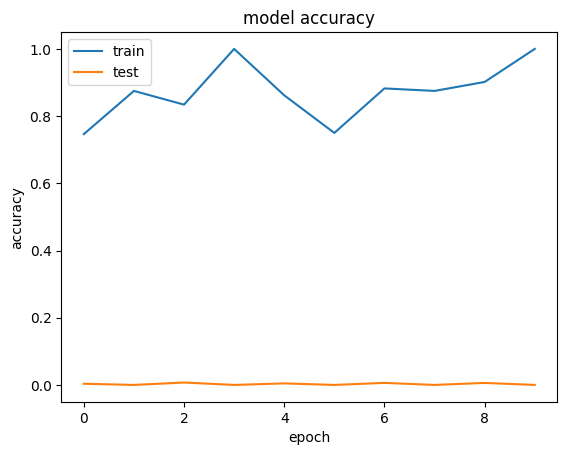

In [23]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

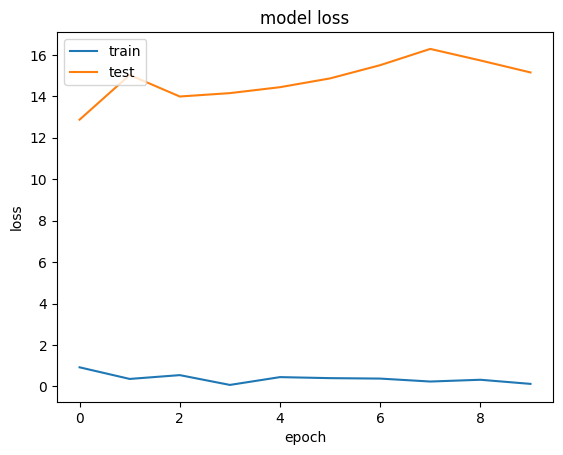

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()